In [91]:
from tensorflow import keras

In [92]:
# Loading the outputs of word2vec
with open('/content/input/metadata.tsv', 'r') as fp:
    lines_of_wtovec_string = fp.readlines()

with open('/content/input/vectors.tsv', 'r',encoding='utf-8') as fp:
    lines_of_wtovec_vec = fp.readlines()


# Building the dictionary
i=0
dictionary = dict() #make an empty dict
for line in lines_of_wtovec_string:
    dictionary[lines_of_wtovec_string[i][:-1]] = lines_of_wtovec_vec[i][:-1]
    i=i+1
    
# Conversion: words->indicies, indicies->words
words_indicies = dict((w, i) for i, w in enumerate(dictionary.keys()))
indicies_words = dict((i, w) for i, w in enumerate(dictionary.keys()))

In [93]:
# This function filters out the unnecessary symbols
# Input: txt file
# Output: transformed_words, transformed_labels
import re
def dict_transformer(path_to_txt):
  with open(path_to_txt, 'r',encoding='utf-8') as fp: 
    linesofdatabasetrain = fp.readlines()

  transformed_words = []
  transformed_labels = []
  for line in linesofdatabasetrain:
    line = re.sub('[<>]', '', line) #hulye jelek kiszurese
    wordsarray = line[:-1].split(' ') #minus1 a \n kiszuresere
    for word in wordsarray:
      #print(word)
      try:
        transformed_labels.append(words_indicies[word])
        word=dictionary[word]
        transformed_words.append(word)
      except:
        transformed_labels.append(words_indicies['[UNK]'])
        word=dictionary['[UNK]']
        transformed_words.append(word)

  return transformed_words, transformed_labels


        
        

In [94]:
# We will use these to train the model
train_data_path = '/content/input/databasetrain.txt'
wordstransfomedarraytrain, wordstransfomedarraytrain_labels = dict_transformer(train_data_path)

test_data_path = '/content/input/databasetest.txt'
wordstransfomedarraytest, wordstransfomedarraytest_labels = dict_transformer(test_data_path)

valid_data_path = '/content/input/databasevalid.txt'
wordstransfomedarrayvalid, wordstransfomedarrayvalid_labels = dict_transformer(test_data_path)

In [95]:
# print(wordstransfomedarraytrain_labels[0:10])
# kappa = [indicies_words[word] for word in list(wordstransfomedarraytrain_labels)[0:20]]
# print(kappa)

In [96]:
# #2. kitalaljuk a modellt
# 1. modell  x:1. szó y:2.szó

# 2. model lstm x:1.szó y:2.szó

# 3. modell rnn

# 4. attention based

# 5. transformer

In [97]:
# wordstransfomedarraytrain_labels[0:10]

In [98]:
#for i in range(0,50):
#  print(indicies_words[int(X_indices[i, 0])], indicies_words[int(X_indices[i, 1])], indicies_words[int(y_indices[i])])
  

In [99]:
# X_matrix, _, X_indices, y_indices, y_matrix_categorical = io_generator(index = 0, window_size=3, input_size=input_size)

In [100]:
# for i in range(0,1):
  # print('X: ', X_indices[i, :], '    y1: ',np.argmax(y_matrix_categorical[i,:]), '  y2: ', y_indices[i+1])
#   print(X_indices[i, :], np.argmax(y_matrix_categorical[i,:]))
  

In [101]:
# indicies_words[2]

In [102]:
import numpy as np



# This function generates the input for the model
# Input: index: here we specify at which index we start the generation from.
#               default: 0, that is we start from the beginning
#        windows_size: length(input + output), where length(output) = 1
def io_generator(index = 0, window_size = 4, input_size = 1, window_step = 1):
  X_matrix_big = np.zeros((1, window_size - 1, 128))
  y_matrix_categorical_big = np.zeros((1, len(dictionary)))
  y_indices_big = np.zeros((1))
  X_indices_big = np.zeros((window_size - 1))
  # y_indices_big = []
  for i in range(input_size):
    float_vector = [] # for temporarly storing one line of vectors
    float_matrix = []
    for row in list(wordstransfomedarraytrain[index:index+window_size]): # 0: 0 + 1 that is: 0, 1. word
      for str_number in row.split():
        float_vector.append(float(str_number))
      float_matrix.append(float_vector) # [], word0, word1
      float_vector = []
    X = float_matrix[0:-1]
    y = float_matrix[-1]
    
    
    # We also save the indicies for the specific words. 
    # These indicies represent positions in the dictionary
    # We need y_indicies to be able to one-hot encode y
    indices = wordstransfomedarraytrain_labels[index:index+window_size]
    X_indices = indices[0:-1]
    y_indices = indices[-1]
    y_categorical = keras.utils.to_categorical(y_indices, len(dictionary))
    
    index = index + window_step
    
    
    X_matrix = np.atleast_3d(X)
    X_matrix = X_matrix.reshape(1, window_size - 1, 128)
    y_matrix_categorical = np.atleast_3d(y_categorical)
    y_matrix_categorical = y_matrix_categorical.reshape(1,len(dictionary))

    X_matrix_big = np.vstack((X_matrix_big, X_matrix))
    y_matrix_categorical_big = np.vstack((y_matrix_categorical_big, y_matrix_categorical))
    y_indices_big = np.vstack((y_indices_big, y_indices))
    X_indices_big = np.vstack((X_indices_big, X_indices))
    # y_indicies_big.append(y_indices)

  # X_matrix = np.delete(X_matrix_big, 0, 0)
  # y_matrix_categorical = np.delete(y_matrix_categorical_big, 0, 0)
  X_matrix = X_matrix_big

  y_indices = y_indices_big
  X_indices = X_indices_big
  y_matrix_categorical = y_matrix_categorical_big
  # return X_matrix[1:, :, :], y, X_indices[1:, :, :], y_indices[1:, :], y_matrix_categorical[1:, :]
  return X_matrix[1:, :, :], y, X_indices[1:, :], y_indices[1:, :], y_matrix_categorical[1:, :]



# In our dictionary, both the keys and the values are strings
# We need to convert the dictionary.values to floats
# This is what this function does
# Input: dictionary
# Output: float_dictionary
def dictionary_to_float_dictionary(dictionary):
  float_dictionary = dict()
  for k, v in dictionary.items():
    vector = [float(str_number) for str_number in v.split()  ]
    vector = np.asarray(vector)
    float_dictionary[k] = vector
  return float_dictionary

# Now we have a dictionary with keys as strings and values as float vectors
float_dictionary = dictionary_to_float_dictionary(dictionary)


# Here we generate the input matrices for the model.
# To do so we call the io_generator() function iteratively, with increasing index.
# It generates input & output sequences
# Iteratively calling it we append its return values to the matrices we want to create.
X_matrix = []
y_matrix = []
y_encoded_matrix = []
n_input = 10
for i in range(0, n_input):
  X, y, _, _, y_categorical = io_generator(index = i)
  X_matrix.append(X)
  y_matrix.append(y)
  y_encoded_matrix.append(y_categorical)

##### Riht now we are not using the above code #####



In [103]:
# Testing for the first input (which will be the 4th word in the training data)
# X, y, _, _, y_categorical = io_generator(index = 0)
# indicies_words[np.argmax(y_categorical)]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM # , GRU
from tensorflow.keras.optimizers import RMSprop

hist_saved = []

# Log fájl inicializálás / fejléc
with open('hyperas-fashionmnist-log.csv', 'w') as csv_file:
  csv_file.write('window_size' + ';')
  csv_file.write('n_lstm' + ';')
  csv_file.write('optimizer' + ';')
  csv_file.write('best_val_acc' + '\n')




window_size = [3, 4, 8, 12]
n_lstm = [16, 32, 128, 256]
optimizer = ['rmsprop', 'adam']

#window_size = [4]
#n_lstm = [128]
#optimizer = ['rmsprop']
#optimizer = ['rmsprop']

  
for i in range(len(window_size)):
  for j in range(len(n_lstm)):
    for k in range(len(optimizer)):
      print('Running with values: window_size = ', window_size[i], ', n_lstm = ', n_lstm[j], ', optimizer = ', optimizer[k])


      # Hyperparameters 1
      # window_size = 4 # window_size --> we only feed in 3 words at a time
      step = 1 # jumping 1 word at a time




      # Creating the model
      model = Sequential()
      model.add(LSTM(n_lstm[j], input_shape = (window_size[i] -1 , 128) )) # , return_sequences=True)) # number of words x dimension of word matrix
      # model.add(Dropout(0.2))
      # model.add(LSTM(128))
      # model.add(Dropout(0.2))
      model.add(Dense(len(dictionary))) # other: y_matrix.shape[1]
      model.add(Activation('softmax'))

      # optimizer = RMSprop(lr = 0.01)
      # optimizer = 'adam'
      # optimizer = 'rmsprop'


      model.compile(loss = 'categorical_crossentropy',
                    metrics = ['accuracy'],
                    optimizer = optimizer[k])

      # Training the model
      # Hyperparameters 2
      n_iterations = 1
      input_size = 1000
      window_step = 1
      index = 0
      
      X_matrix_saved = []
      y_matrix_categorical_saved = []
      for itr in range(n_iterations):
        X_matrix, _, _, _, y_matrix_categorical = io_generator(index = index,
                                                              window_size=window_size[i],
                                                              input_size=input_size,
                                                              window_step = window_step)
        X_matrix_saved.append(X_matrix)
        y_matrix_categorical_saved.append(y_matrix_categorical)
        # X_matrix_saved.

        # Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
        patience=10
        early_stopping=EarlyStopping(patience=patience, verbose=1)
        # Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
        checkpointer=ModelCheckpoint(filepath='model_' + str(i) + str(j) + str(k) +'.hdf5', save_best_only=True, monitor = "loss", verbose=0)
        tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)


        history = model.fit(x = X_matrix,
                  y = y_matrix_categorical,
                  batch_size=128,
                  verbose = 0,
                  epochs=40,
                  callbacks=[early_stopping, checkpointer, tb]
                  )
        hist_saved.append(history)
        index = index + input_size * window_step
        print(itr)
        
        best_val_acc = max(history.history['accuracy'])
        # Log kiírása: háló struktúra, és az eredmény
        with open('hyperas-fashionmnist-log.csv', 'a') as csv_file:
          csv_file.write(str(window_size[i]) + ';')
          csv_file.write(str(n_lstm[j]) + ';')
          csv_file.write(str(optimizer[k]) + ';')
          csv_file.write(str(best_val_acc) + '\n')


  



In [106]:
# Printing best models
import pandas
df = pandas.read_csv('hyperas-fashionmnist-log.csv', delimiter=';')
df.sort_values(by=['best_val_acc'], ascending=False)

,window_size,n_lstm,optimizer,best_val_acc
14,4,256,rmsprop,0.601
22,8,256,rmsprop,0.551
6,3,256,rmsprop,0.504
30,12,256,rmsprop,0.463
7,3,256,adam,0.377
15,4,256,adam,0.350
4,3,128,rmsprop,0.307
12,4,128,rmsprop,0.302
20,8,128,rmsprop,0.287
28,12,128,rmsprop,0.270


In [107]:
# Print the best 10 models
hyperas_log = pandas.read_csv('hyperas-fashionmnist-log.csv', delimiter=';')
hyperas_best10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).head(n=5)
hyperas_best10

,window_size,n_lstm,optimizer,best_val_acc
14,4,256,rmsprop,0.601
22,8,256,rmsprop,0.551
6,3,256,rmsprop,0.504
30,12,256,rmsprop,0.463
7,3,256,adam,0.377


In [108]:
# Print the worst 10 models
hyperas_worst10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).tail(n=5)
hyperas_worst10

,window_size,n_lstm,optimizer,best_val_acc
16,8,16,rmsprop,0.185
24,12,16,rmsprop,0.184
26,12,32,rmsprop,0.184
27,12,32,adam,0.184
29,12,128,adam,0.184


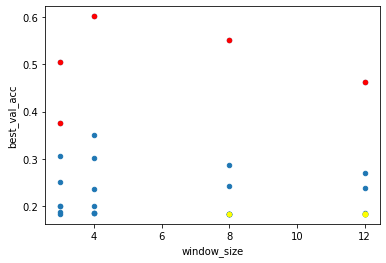

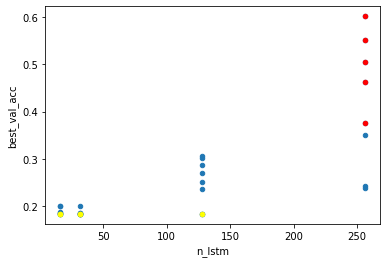

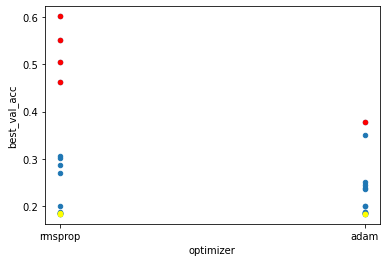

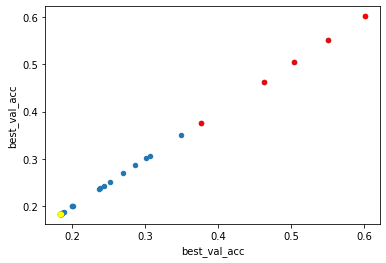

In [109]:
import matplotlib.pyplot as plt

for hyperparam in [ 'window_size', 'n_lstm', 'optimizer', 'best_val_acc']:
  ax1 = hyperas_log.plot(kind='scatter', x=hyperparam, y='best_val_acc')
  hyperas_best10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='red', ax=ax1)
  hyperas_worst10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='yellow', ax=ax1)


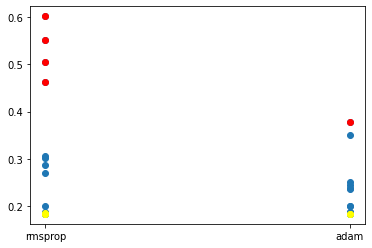

In [110]:
plt.scatter(hyperas_log.optimizer, hyperas_log.best_val_acc)
plt.scatter(hyperas_best10.optimizer, hyperas_best10.best_val_acc, color='red')
plt.scatter(hyperas_worst10.optimizer, hyperas_worst10.best_val_acc, color='yellow')
plt.show()

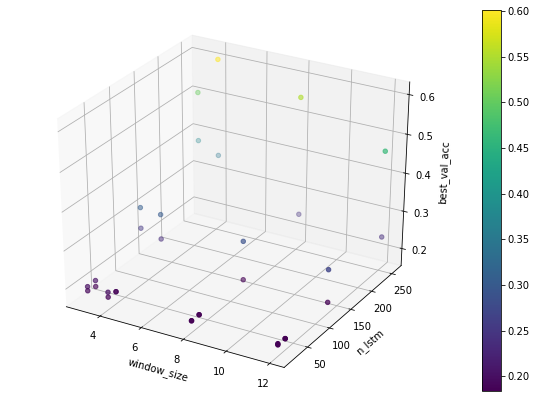

In [124]:
# How are the hyperparameters and the val_acc realated?
from mpl_toolkits.mplot3d import Axes3D
# Let's plot the relation of n_filters1 / n_filters2 and the best_val_acc
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.window_size, hyperas_log.n_lstm, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('window_size')
ax.set_ylabel('n_lstm')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

In [ ]:
# Printing out the loss function
import matplotlib.pyplot as plt

for hist in hist_saved[:40]:
  plt.plot(hist.history['loss'])


In [ ]:
"""
for i in range(1):
  plt.plot( [np.argmax(value) for value in y_matrix_categorical_saved[i]] )

kappa = X_matrix_saved[1]
kappa.shape
for i in range(kappa.shape[0]):
  plt.plot(kappa[i, 1, :])

plt.plot( [ value in X_matrix_saved[:, 1, :]]
"""

In [ ]:
)

In [122]:
# This function return the vector form of the model output
# (First it converts it to index and the using indicies_words it 
# transformes the index to the vector form)
# Input: model_output
# Output: vector from of the model_output
def model_output_to_vector(model_output):
  szo = indicies_words[np.argmax(model_output)]
  vector = float_dictionary[szo]
  return vector

# This function deletes the first element of the input vector
# and appends a new element to the last position.
# We use this for text generation.
# Input: old_input, new_vector
# Output: new_input
def refresh_input(old_input, new_vector):
  new_input = np.zeros(old_input.shape)
  dim = old_input.shape[1]
  new_input[0,:(dim - 1), : ] = old_input[0, 1:dim, :]
  new_input[0, dim - 1, :] = new_vector
  return new_input


# mintavétel, ami újrasúlyozza a predikciót a temperature változó alapján 
# Function for sampling. It re-weights the prediction depending on the temperature variable
# Input: preds : the distribution to be re-weighted
#        temperature : changes the distribution. The heigher we set the value, the more it changes
#                      If we want to have a good impact, we encourage the user to set temperature >= 2
def sample(preds, temperature=2):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds) # Az összes lehetőség egyre szummázódjon (lásd softmax képlet)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas), preds




# This function generates text using the trained model.
# Input: input: the starting sequence
#        n_to_generate: this is how many words will be automatically generated 
#                       using "input" as starting sequence
# Output: text: the generated string
def word_generator(input, input_indicies = None, n_to_generate = 50):
  text = []
  text_indicies = []
  for i in range(n_to_generate):
    output = model.predict(input)
    output_arg, output = sample(output[0, :])
    output = np.asarray(output).astype('float32')
    output = output * 0
    output[output_arg] = 1
    # print(' Ezeknek kéne megegyezniük, de a tempearture miatt nem :) --> ', output_arg, np.argmax(output))
    text.append(indicies_words[np.argmax(output)])
    text_indicies.append(np.argmax(output))
    # vector = model_output_to_vector(model_output = output)
    vector = model_output_to_vector(model_output = indicies_words[output_arg])
    new_input = refresh_input(old_input = input, new_vector = vector)
    input = new_input
  return text, text_indicies


"""
### --- Szöveg predikálás --- ###
"""
# Generating an input from the beginning of the corpus
input, _, input_indicies, _, _ = io_generator(index = 0,  window_size=window_size[-1])
# Feeding the input to the text generator & predicting a text sequence.
text, text_indicies = word_generator(input=input, input_indicies = input_indicies)

print(' A predikált text:', text)

 A predikált text: ['nemcsak', 'vele', 'egyszerre', '17', 'csak', 'elfogyott', 'john', 'kérdeztem', 'nekem', 'hát', 'már', 'pont', 'leszek', 'pont', 'éve', 'a', 'gyerek', 'délután', 'akar', 'nem', 'is', 'vesszõ', 'kicsit', 'kettõspont', 'házába', 'semmit', 'ilyen', 'úgyis', 'velem', 'mindig', 'vesszõ', 'megyek', 'belső', 'tud', 'már', 'vesszõ', 'is', 'ilyen', 'kicsit', 'eső', 'már', 'mellett', 'azt', 'észak', 'megy', 'magamat', 'vesszõ', 'engedett', 'lesz', 'édesanyám']


In [118]:
# Evaluating the performance on a specific input
input, _, input_indicies, y_indices, y_matrix_categorical = io_generator(index = 0,  window_size=window_size[-1], input_size=1000)
model.evaluate(x=input, y=y_matrix_categorical)

32/32 [==============================] - 1s 19ms/step - loss: 3.7055 - accuracy: 0.2310


[3.7054593563079834, 0.23100000619888306]